In [1]:
import numpy as np
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn.utils as sklu
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.model_selection import cross_val_score, RepeatedKFold, cross_val_predict
import sklearn.model_selection as le_ms
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as skpp
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score, auc
import sklearn.metrics as sklm
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
import hyperopt.hp as hpo
import warnings
warnings.filterwarnings('ignore')



In [2]:
df = pd.read_csv("DATASET_clean.csv")
X = df.drop(columns= ['a1c_test']).copy() # make a copy of only the x variables
y = df['a1c_test'] # isolate the outcome (y variable)
X_train, X_test, y_train, y_test = le_ms.train_test_split(X, y, random_state=12345, train_size=0.8, stratify = y)

columns = X_train.columns

In [3]:
N_SPLITS = 10
kfold = le_ms.StratifiedKFold(n_splits = N_SPLITS)


In [4]:
# set the parameter space and values for the algorithm to search through
space = {'max_depth': hp.quniform("max_depth", 1, 20, 1),
            'gamma': hp.uniform('gamma', 0,25),
            'reg_alpha': hp.quniform('reg_alpha', 0, 100, 1),
            'reg_lambda': hp.uniform('reg_lambda', 0,250),
            'colsample_bytree': hp.uniform('colsample_bytree', 0,1),
            'min_child_weight': hp.quniform('min_child_weight', 0, 200, 1),
            'n_estimators': 180,
            'eval_metric': 'auc',
            'random_state': [1234],
            'early_stopping': 50,
         'scale_pos_weight': hp.quniform('scale_pos_weight', 0, 200, 1)
}

In [5]:
def hyperparameter_tuning(space):
    #classes_weights = sklu.class_weight.compute_sample_weight(
    #class_weight='balanced',
    #y=trainY)
    model = xgb.XGBClassifier(#n_estimators =space['n_estimators'],
                                max_depth = int(space['max_depth']), gamma = space['gamma'],
                                reg_alpha = int(space['reg_alpha']), min_child_weight=space['min_child_weight'],
                                colsample_bytree = space['colsample_bytree'], eval_metric = 'auc',scale_pos_weight=int(space['scale_pos_weight']),
        
        
        n_jobs=-1)
   


    model.fit(trainX, trainY, verbose=False)

    #pred = model.predict(testX)
    y_pred = model.predict_proba(testX)
    y_true = np.array(testY)
    y_scores = y_pred[:, 1]

    fpr, tpr, _ = sklm.roc_curve(testY, y_scores)
    #AUC = sklm.roc_auc_score(testY, pred)
    roc_auc = sklm.auc(fpr, tpr)
    #print(roc_auc)
    
    return {'loss':-roc_auc, 'status': STATUS_OK, 'model': model}

In [6]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [7]:
max_depth_list = []
auc_list = []
gamma_list = []
reg_alpha_list = []
reg_lambda_list = []
col_sample_by_tree_list = []
min_child_weight_list = []
scale_pos_weight_list = []
np.random.seed(1234567)
for train_index, test_index in kfold.split(range(len(y_train)), y = y_train):
    
    # split labels and feature matrix
    trainX = X_train[train_index]
    trainY = y_train[train_index]
    testX = X_train[test_index]
    testY = y_train[test_index]
    rstate = np.random.default_rng(1234) # note that you must set this so that the fmin is reproducible
    # run the algorithm
    #scaler = skpp.MinMaxScaler()
    #scaler.fit(trainX)
    #trainX = scaler.transform(trainX)
    #testX = scaler.transform(testX)
    trials = Trials()
    best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials,
            rstate=rstate)

    print(best) # print the best parameter values
    # extract the best model
    best_loss = trials.best_trial['result']['loss'] 
    print(best_loss)

    auc_list.append(best_loss)
    max_depth_list.append(best['max_depth'])
    gamma_list.append(best['gamma'])
    reg_alpha_list.append(best['reg_alpha'])
    reg_lambda_list.append(best['reg_lambda'])
    col_sample_by_tree_list.append(best['colsample_bytree'])
    min_child_weight_list.append(best['min_child_weight'])
    scale_pos_weight_list.append(best['scale_pos_weight'])

100%|█████████████████████████████████████████████| 200/200 [00:10<00:00, 19.71trial/s, best loss: -0.7969999999999999]
{'colsample_bytree': 0.8075507353281677, 'gamma': 3.061513672845491, 'max_depth': 14.0, 'min_child_weight': 151.0, 'reg_alpha': 25.0, 'reg_lambda': 39.39261964150139, 'scale_pos_weight': 72.0}
-0.7969999999999999
100%|███████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.25trial/s, best loss: -0.781875]
{'colsample_bytree': 0.9553992977880051, 'gamma': 22.43008944639638, 'max_depth': 8.0, 'min_child_weight': 196.0, 'reg_alpha': 24.0, 'reg_lambda': 180.97618774533515, 'scale_pos_weight': 64.0}
-0.781875
100%|███████████████████████████████████████████████████████| 200/200 [00:08<00:00, 22.83trial/s, best loss: -0.802125]
{'colsample_bytree': 0.008109877557940529, 'gamma': 1.814991417604436, 'max_depth': 7.0, 'min_child_weight': 50.0, 'reg_alpha': 43.0, 'reg_lambda': 63.40050630343604, 'scale_pos_weight': 16.0}
-0.802125
100%|████████████████

In [8]:
test_set_auc = []
np.random.seed(123456)
for i in range(0, 10, 1):
    print(i)
    model = xgb.XGBClassifier(
                                max_depth = int(max_depth_list[i]), gamma = gamma_list[i],
                                reg_alpha = int(reg_alpha_list[i]), min_child_weight=min_child_weight_list[i], reg_lambda = reg_lambda_list[i],
                                colsample_bytree = col_sample_by_tree_list[i], eval_metric = 'auc',scale_pos_weight = int(scale_pos_weight_list[i]), n_jobs=-1)


    model.fit(X_train, y_train, verbose=False)

    y_pred = model.predict_proba(X_test)
    y_true = np.array(y_test)
    y_scores = y_pred[:, 1]

    fpr, tpr, _ = sklm.roc_curve(y_test, y_scores)
    #AUC = sklm.roc_auc_score(testY, pred)
    roc_auc = sklm.auc(fpr, tpr)
    print(roc_auc)
    test_set_auc.append(roc_auc)
    print("Maximum AUC position: ",test_set_auc.index(max(test_set_auc)) )
    i = test_set_auc.index(max(test_set_auc))#best i

0
0.7662059294871795
Maximum AUC position:  0
1
0.7745492788461539
Maximum AUC position:  1
2
0.7651442307692309
Maximum AUC position:  1
3
0.7816506410256411
Maximum AUC position:  3
4
0.7857371794871795
Maximum AUC position:  4
5
0.7769030448717948
Maximum AUC position:  4
6
0.7522435897435896
Maximum AUC position:  4
7
0.7762219551282051
Maximum AUC position:  4
8
0.7747395833333334
Maximum AUC position:  4
9
0.7822415865384617
Maximum AUC position:  4


In [9]:
np.random.seed(1234567)
model = xgb.XGBClassifier(
                                max_depth = int(max_depth_list[i]), gamma = gamma_list[i],
                                reg_alpha = int(reg_alpha_list[i]), min_child_weight=min_child_weight_list[i], reg_lambda = reg_lambda_list[i],
                                colsample_bytree = col_sample_by_tree_list[i], eval_metric = 'auc',scale_pos_weight = int(scale_pos_weight_list[i]), n_jobs=-1)


model.fit(X_train, y_train, verbose=False)

y_pred = model.predict_proba(X_test)
y_true = np.array(y_test)
y_scores = y_pred[:, 1]

fpr, tpr, _ = sklm.roc_curve(y_test, y_scores)
#AUC = sklm.roc_auc_score(testY, pred)
roc_auc = sklm.auc(fpr, tpr)
print(roc_auc)

0.7857371794871795


In [10]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
roc_auc_XGB = auc(fpr, tpr)

In [12]:
# Load and preprocess
df = pd.read_csv("DATASET_clean.csv")
X = df.drop(columns=["SEQN", "a1c_test"])
y = df["a1c_test"]
cat_cols = ['ALQ111', 'SMQ020', 'DPQ010', 'DPQ040', 'DPQ050', 'DPQ060', 'DMDBORN', 'DMDEDUC', 'DMDMARTX']
X[cat_cols] = X[cat_cols].astype("category")

In [13]:
from imblearn.over_sampling import SMOTENC

X = df.drop(columns=["SEQN", "a1c_test"])
y = df["a1c_test"]

y = y.astype('category')
y.value_counts()


a1c_test
0    3122
1     398
Name: count, dtype: int64

In [14]:

X_factors = ['ALQ111', 'SMQ020', 'DPQ010', 'DPQ040', 'DPQ050', 'DPQ060', 'DMDBORN', 'DMDEDUC', 'DMDMARTX']
X[X_factors] = X[X_factors].astype('category')

### SMOTE NC function
sm = SMOTENC(random_state=42, categorical_features= ['ALQ111', 'SMQ020', 'DPQ010', 'DPQ040', 'DPQ050', 'DPQ060', 'DMDBORN', 'DMDEDUC', 'DMDMARTX'])
X_res, y_res = sm.fit_resample(X, y)


### CONFIRM NEW COUNT
y_res.value_counts()

a1c_test
0    3122
1    3122
Name: count, dtype: int64

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_res)
X_res_scaled = sc.transform(X_res)


### balanced data is named X_res_scaled, and y_res
### split data into train and test
from sklearn.model_selection import train_test_split
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_res_scaled, y_res, test_size=0.2, random_state=50)

In [16]:
param_grid = {'C': [0.1,1, 2,3,4, 5]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    SVC(kernel='linear', probability=True),
    param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train)

# Evaluation
model_best = grid.best_estimator_
y_pred = model_best.predict(X_test_scaled)
print("\n🔹 GridSearch SMOTE Linear SVM")
print("Best Params:", grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


y_proba = model_best.predict_proba(X_test_scaled)[:, 1]
fpr_smote, tpr_smote, thresholds = roc_curve(y_test, y_proba)
roc_auc_svm = auc(fpr_smote, tpr_smote)


🔹 GridSearch SMOTE Linear SVM
Best Params: {'C': 2}
Accuracy: 0.789431545236189
RMSE: 0.4588773853262013
Confusion Matrix:
 [[470 173]
 [ 90 516]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.73      0.78       643
           1       0.75      0.85      0.80       606

    accuracy                           0.79      1249
   macro avg       0.79      0.79      0.79      1249
weighted avg       0.80      0.79      0.79      1249



In [56]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


log_reg = LogisticRegression(penalty='l1', C=10, random_state=10, solver='saga', max_iter = 10000)
log_reg.fit(X_train_scaled, y_train.values.ravel())
y_proba_log_reg = log_reg.predict_proba(X_test_scaled)[:, 1]

#random forest
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train.values.ravel())
y_proba_ran_for = rf.predict_proba(X_test_scaled)[:,1]

fpr_log_reg_balanced, tpr_log_reg_balanced, _ = roc_curve(y_test.values.ravel(), y_proba_log_reg )
auc_log_reg_balanced = roc_auc_score(y_test.values.ravel(), y_proba_log_reg)

fpr_ran_for_balanced, tpr_ran_for_balanced, _ = roc_curve(y_test.values.ravel(), y_proba_ran_for )
auc_ran_for_balanced = roc_auc_score(y_test.values.ravel(), y_proba_ran_for)
from sklearn.model_selection import cross_validate
scores = cross_validate(rf, X, y, cv=5, return_train_score=True)

print("Train Accuracy:", scores['train_score'].mean())
print("Test Accuracy:", scores['test_score'].mean())




Train Accuracy: 1.0
Test Accuracy: 0.8857954545454547


In [50]:
print(auc_ran_for_balanced)
print(auc_log_reg_balanced)
print(roc_auc_XGB)
print(roc_auc_svm)


0.9786132967884658
0.862759137500064
0.7857371794871795
0.8633416996443034


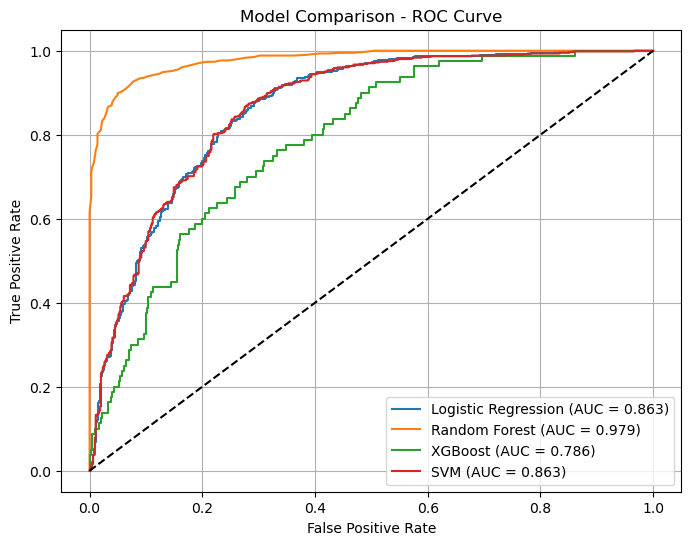

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg_balanced, tpr_log_reg_balanced, label=f'Logistic Regression (AUC = {auc_log_reg_balanced:.3f})')
plt.plot(fpr_ran_for_balanced, tpr_ran_for_balanced, label=f'Random Forest (AUC = {auc_ran_for_balanced:.3f})')
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_XGB:.3f})')
plt.plot(fpr_smote, tpr_smote, label=f'SVM (AUC = {roc_auc_svm:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Model Comparison - ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()